# SC4002 / CE4045 / CZ4045 NLP — Part 3.3: Enhancements

This notebook reuses the serialized TREC pipeline prepared in Part 3.1 and improves the base model specified in part 2.

## Setup

Import the same dependencies used in the biLSTM/biGRU notebook so the experiment can plug into the shared data loaders and utilities.

In [16]:
import sys, os, math, random, time
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from collections import defaultdict

import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

## Data & Vocab Loading

Load the serialized torchtext artifacts so the iterators, vocabulary, and pretrained embeddings exactly match the previous experiments.

In [17]:
LOAD_PREPARED = True

if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")

    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])

    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}

    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    PAD_IDX = TEXT.vocab.stoi.get(TEXT.pad_token, 0)
    print("Artifacts loaded.")
else:
    raise RuntimeError("Set LOAD_PREPARED=True to reuse the serialized pipeline.")

Artifacts loaded.


## Training Utilities

Utility functions copied from the biLSTM/biGRU notebook so the training/evaluation logic stays consistent.

In [18]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


def _extract_batch(batch):
    if hasattr(batch, 'text'):
        text, lengths = batch.text
        labels = batch.label
    else:
        text, lengths, labels = batch
    if text.dim() == 2 and text.size(0) != lengths.size(0):
        text = text.transpose(0, 1)  # -> [batch, seq_len]
    return text, lengths, labels


def train_loop(model, iterator, optimizer, criterion, grad_clip=None, max_norm=1.0):
    model.train()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    for batch in iterator:
        text, lengths, labels = _extract_batch(batch)

        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits, labels)
        extra_loss = getattr(model, 'extra_loss', None)
        if extra_loss is not None:
            loss = loss + extra_loss
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_examples += labels.size(0)
        total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def eval_loop(model, iterator, criterion):
    model.eval()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            loss = criterion(logits, labels)
            extra_loss = getattr(model, 'extra_loss', None)
            if extra_loss is not None:
                loss = loss + extra_loss

            total_loss += loss.item()
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
            total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def test_loop(model, iterator):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / max(total_examples, 1)


def topic_eval_loop(model, iterator, label_vocab):
    model.eval()
    n = len(label_vocab.itos)
    correct = [0] * n
    total = [0] * n
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            preds = torch.argmax(logits, dim=1)
            for p, y in zip(preds.tolist(), labels.tolist()):
                total[y] += 1
                correct[y] += int(p == y)
    per_topic = {}
    for idx, lab in enumerate(label_vocab.itos):
        if total[idx] == 0:
            per_topic[lab] = float('nan')
        else:
            per_topic[lab] = correct[idx] / total[idx]
    return per_topic

### Model-specific upgrades

We first explore whether adding **attention** to an RNN improves performance. Our intuition is simple: attention helps the model **focus on the most relevant words** in a sentence instead of treating all tokens equally. Starting from this idea, we vary only the **encoder and pooling** pieces to see which architectural change helps most, while keeping training settings constant.

**Model A — RNN with additive attention (single view).**
We take a GRU encoder and replace fixed pooling (mean/max/last) with **additive attention**. The attention scorer assigns a weight to each timestep (with padding masked), builds a weighted summary, and passes that to the classifier. This is the simplest “focus” mechanism—one learned view over the sequence.

**Model A2 — RNN with multi-head additive attention (multiple views).**
We keep the same GRU but use **several additive heads** in parallel. Each head can focus on a different part of the sentence (e.g., the question word vs. the entity). We then merge the heads’ summaries before classification. This tests whether **multiple focused views** beat a single one.

**Model B — RNN with self-attention pooling.**
We still use the GRU for token features, but we **swap the pooling step** for **self-attention**: the sequence forms its own queries/keys/values and computes a pooled summary (multi-head, masked). This lets tokens **look at each other** once more before we summarize, which can highlight non-adjacent but related words.

**Model C — CNN → RNN → attention (phrase detectors first).**
We add a small **CNN front-end** before the GRU to detect short **n-grams** (e.g., “how many”, “capital of”). Those enriched features go into the GRU, and we finish with the same attention pooling. Here we test whether giving attention **better local cues** up front leads to a stronger final summary.

**Model D — Transformer encoder → same attention head.**
We replace the GRU with a **lightweight Transformer** (with positional encodings) so every token can attend to every other token during encoding. We keep the **same additive attention** at the end so the only major change is the **encoder’s inductive bias** (global context vs. recurrent). This checks if a global reader plus the same focus step performs better.

Across A→D, the differences are straightforward:

1. learn to focus with a **single** attention view (A),
2. use **multiple** attention views (A2),
3. let tokens **re-attend each other** during pooling (B),
4. add **phrase detectors** before the RNN (C), and
5. switch to a **Transformer** encoder while keeping the same attention readout (D).

All models are trained and evaluated under the **same data and optimization settings**, so any improvements can be linked to these architectural choices rather than training differences.

In [86]:

class AttentionPooling(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, attn_dim)
        self.score = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, rnn_outputs, mask):
        scores = self.score(torch.tanh(self.proj(rnn_outputs))).squeeze(-1)
        scores = scores.masked_fill(~mask, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs).squeeze(1)
        return context, attn_weights


class MultiHeadAttentionPooling(nn.Module):
    """
    Multi-head additive attention pooling over timestep features with optional
    diversity regularization to discourage head collapse.
    """
    def __init__(self, input_dim, attn_dim, num_heads,
                 merge='concat', temperature=1.0, score_dropout=0.0,
                 diversity_regularizer=False):
        super().__init__()
        if num_heads < 2:
            raise ValueError("num_heads must be >= 2 for multi-head attention.")
        if attn_dim % num_heads != 0:
            raise ValueError("attn_dim must be divisible by num_heads.")
        if merge not in {'concat', 'mean', 'max'}:
            raise ValueError("merge must be 'concat', 'mean', or 'max'.")
        if temperature <= 0:
            raise ValueError("temperature must be > 0.")

        self.num_heads = num_heads
        self.merge = merge
        self.temperature = float(temperature)
        self.score_drop = nn.Dropout(score_dropout) if score_dropout > 0 else nn.Identity()
        self.track_diversity = diversity_regularizer and num_heads > 1
        self.last_diversity = None

        per_head = attn_dim // num_heads
        self.proj = nn.ModuleList([nn.Linear(input_dim, per_head) for _ in range(num_heads)])
        self.scorers = nn.ModuleList([nn.Linear(per_head, 1, bias=False) for _ in range(num_heads)])
        self.out_proj = nn.Linear(input_dim * num_heads, input_dim) if merge == 'concat' else None

    def _compute_diversity(self, attn_weights):
        # attn_weights: [B, T, K]
        weights = attn_weights.transpose(1, 2)  # [B, K, T]
        gram = torch.bmm(weights, weights.transpose(1, 2))  # [B, K, K]
        eye = torch.eye(self.num_heads, device=weights.device).unsqueeze(0)
        off_diag = gram * (1 - eye)
        return off_diag.mean()

    def forward(self, rnn_outputs, mask):
        B, T, _ = rnn_outputs.shape
        K = self.num_heads

        head_contexts = []
        head_weights = []

        for k in range(K):
            h = torch.tanh(self.proj[k](rnn_outputs))
            scores_k = self.scorers[k](h).squeeze(-1)
            scores_k = scores_k.masked_fill(~mask, float('-inf'))
            scores_k = scores_k / self.temperature
            scores_k = self.score_drop(scores_k)
            alpha_k = torch.softmax(scores_k, dim=1)
            ctx_k = torch.bmm(alpha_k.unsqueeze(1), rnn_outputs).squeeze(1)
            head_contexts.append(ctx_k)
            head_weights.append(alpha_k)

        contexts = torch.stack(head_contexts, dim=1)
        attn_weights = torch.stack(head_weights, dim=-1)

        if self.merge == 'concat':
            context = self.out_proj(contexts.reshape(B, -1))
        elif self.merge == 'mean':
            context = contexts.mean(dim=1)
        else:
            context, _ = contexts.max(dim=1)

        if self.track_diversity:
            self.last_diversity = self._compute_diversity(attn_weights)
        else:
            self.last_diversity = None

        return context, attn_weights


class SelfAttentionPooling(nn.Module):
    def __init__(self, input_dim, num_heads=4, dropout=0.1):
        super().__init__()
        if num_heads < 1:
            raise ValueError("num_heads must be >= 1 for self-attention pooling.")
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads.")
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.q_proj = nn.Linear(input_dim, input_dim)
        self.k_proj = nn.Linear(input_dim, input_dim)
        self.v_proj = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(input_dim, input_dim)

    def forward(self, rnn_outputs, mask):
        batch_size, seq_len, feat_dim = rnn_outputs.size()
        q = self.q_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        key_mask = ~mask.unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(key_mask, -1e9)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attended = torch.matmul(attn_weights, v)  # [batch, heads, seq_len, head_dim]
        query_mask = mask.unsqueeze(1).unsqueeze(-1)
        attended = attended * query_mask
        denom = query_mask.sum(dim=2).clamp_min(1.0)
        context = attended.sum(dim=2) / denom
        context = context.transpose(1, 2).reshape(batch_size, -1)
        context = self.out_proj(context)

        avg_weights = attn_weights.mean(dim=1)  # [batch, seq_len, seq_len]
        valid = mask.float()
        weighted_sum = (avg_weights * valid.unsqueeze(-1)).sum(dim=1)
        counts = valid.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled_weights = (weighted_sum / counts) * valid
        return context, pooled_weights


class AttentionRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, attn_dim=128, num_heads=1,
                 multihead_merge='concat', padding_idx=0, diversity_coeff=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.num_heads = max(1, num_heads)
        self.diversity_coeff = float(diversity_coeff)
        self.extra_loss = None
        if self.num_heads == 1:
            self.attention = AttentionPooling(feat_dim, attn_dim)
        else:
            self.attention = MultiHeadAttentionPooling(
                feat_dim,
                attn_dim,
                self.num_heads,
                merge=multihead_merge,
                diversity_regularizer=self.diversity_coeff > 0,
            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        self.extra_loss = None
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(embedded, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.attention(outputs, mask)
        self.last_attention = attn_weights
        if self.diversity_coeff > 0 and self.num_heads > 1:
            penalty = getattr(self.attention, 'last_diversity', None)
            if penalty is not None:
                self.extra_loss = self.diversity_coeff * penalty

        logits = self.fc(self.dropout(context))
        return logits


class SelfAttentionRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, num_heads=4, padding_idx=0,
                 self_attn_dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.self_attn = SelfAttentionPooling(feat_dim, num_heads=num_heads, dropout=self_attn_dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(embedded, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.self_attn(outputs, mask)
        self.last_attention = attn_weights

        logits = self.fc(self.dropout(context))
        return logits


class CNNRNNWithAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, attn_dim=128, num_heads=1,
                 conv_channels=128, kernel_sizes=(3, 5), padding_idx=0,
                 diversity_coeff=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.kernel_sizes = kernel_sizes
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(emb_dim, conv_channels, ks, padding=ks // 2)
            for ks in kernel_sizes
        ])
        conv_out_dim = conv_channels * len(kernel_sizes)

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            conv_out_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.num_heads = max(1, num_heads)
        self.diversity_coeff = float(diversity_coeff)
        self.extra_loss = None
        if self.num_heads == 1:
            self.attention = AttentionPooling(feat_dim, attn_dim)
        else:
            self.attention = MultiHeadAttentionPooling(
                feat_dim,
                attn_dim,
                self.num_heads,
                diversity_regularizer=self.diversity_coeff > 0,
            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        self.extra_loss = None
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        conv_in = embedded.transpose(1, 2)
        conv_features = [torch.relu(conv(conv_in)) for conv in self.conv_layers]
        conv_cat = torch.cat(conv_features, dim=1).transpose(1, 2)

        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(conv_cat, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.attention(outputs, mask)
        self.last_attention = attn_weights
        if self.diversity_coeff > 0 and self.num_heads > 1:
            penalty = getattr(self.attention, 'last_diversity', None)
            if penalty is not None:
                self.extra_loss = self.diversity_coeff * penalty

        logits = self.fc(self.dropout(context))
        return logits


class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * (-math.log(10000.0) / emb_dim))
        pe = torch.zeros(max_len, emb_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes, num_layers=2, nhead=4,
                 dim_feedforward=256, dropout=0.1, attn_dim=128, embeddings=None,
                 freeze_embeddings=False, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.pos_encoder = PositionalEncoding(emb_dim, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention = AttentionPooling(emb_dim, attn_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(emb_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        embedded = self.pos_encoder(embedded)

        lengths_device = lengths.to(embedded.device)
        mask = torch.arange(embedded.size(1), device=embedded.device).unsqueeze(0) < lengths_device.unsqueeze(1)
        src_key_padding_mask = ~mask

        encoded = self.encoder(embedded, src_key_padding_mask=src_key_padding_mask)
        context, attn_weights = self.attention(encoded, mask)
        self.last_attention = attn_weights
        logits = self.fc(self.dropout(context))
        return logits


In [96]:
EMB_DIM = pretrained_embeddings.size(1) if pretrained_embeddings is not None else 100
HIDDEN_DIM = 256
NUM_LAYERS = 2
ATTN_DIM = 256
DROPOUT = 0.4
RNN_TYPE = 'gru'
BIDIRECTIONAL = True

LR = 1e-3
EPOCHS = 50
PATIENCE = 3
GRAD_CLIP = 1.0
FREEZE_EMB = False
WEIGHT_DECAY = 0.0

EXPERIMENTS = [
    {
        "name": "model_a_single",
        "label": "Model A — Single-head attention RNN",
        "group": "Model A",
        "model_type": "attn_rnn",
        "num_heads": 1,
        "attn_dim": ATTN_DIM,
        "multihead_merge": "concat",
        "best_path": "attn_rnn_best.pt",
        "history_path": "attn_rnn_history.npz",
        "is_baseline": True,
    },
    {
        "name": "model_a_multihead",
        "label": "Model A2 — Multi-head attention RNN",
        "group": "Model A2",
        "model_type": "attn_rnn",
        "num_heads": 2,
        "attn_dim": ATTN_DIM,
        "multihead_merge": "concat",
        "diversity_coeff": 0.2,
        "best_path": "attn_rnn_multihead_best.pt",
        "history_path": "attn_rnn_multihead_history.npz",
    },
    {
        "name": "model_b_self_attn",
        "label": "Model B — Self-attention RNN",
        "group": "Model B",
        "model_type": "self_attn_rnn",
        "num_heads": 2,
        "attn_dim": ATTN_DIM,
        "best_path": "selfattn_rnn_best.pt",
        "history_path": "selfattn_rnn_history.npz",
        "self_attn_dropout": 0.1,
    },
    {
        "name": "model_c_cnn_rnn",
        "label": "Model C — CNN + RNN + attention",
        "group": "Model C",
        "model_type": "cnn_rnn_attn",
        "num_heads": 1,
        "attn_dim": ATTN_DIM,
        "conv_channels": 128,
        "kernel_sizes": (3, 5),
        "best_path": "cnnrnn_attn_best.pt",
        "history_path": "cnnrnn_attn_history.npz",
    },
    {
        "name": "model_d_transformer",
        "label": "Model D — Transformer encoder + attention",
        "group": "Model D",
        "model_type": "transformer",
        "nhead": 2,
        "num_layers": 2,
        "dim_feedforward": 256,
        "attn_dim": ATTN_DIM,
        "best_path": "transformer_attn_best.pt",
        "history_path": "transformer_attn_history.npz",
    },
]

vocab_size = len(TEXT.vocab)
num_classes = len(LABEL.vocab)
print(f"vocab_size={vocab_size}, num_classes={num_classes}, pad_idx={PAD_IDX}")

emb_matrix = pretrained_embeddings if pretrained_embeddings is not None else None
if emb_matrix is not None and emb_matrix.size(1) != EMB_DIM:
    raise ValueError(f"Embedding dim mismatch: {emb_matrix.size(1)} vs EMB_DIM={EMB_DIM}")

def build_model(exp_cfg):
    model_type = exp_cfg.get('model_type', 'attn_rnn')
    common_kwargs = dict(
        vocab_size=vocab_size,
        emb_dim=EMB_DIM,
        num_classes=num_classes,
        embeddings=emb_matrix,
        freeze_embeddings=FREEZE_EMB,
    )
    if model_type == 'attn_rnn':
        return AttentionRNNClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            num_heads=exp_cfg.get('num_heads', 1),
            multihead_merge=exp_cfg.get('multihead_merge', 'concat'),
            padding_idx=PAD_IDX,
            diversity_coeff=exp_cfg.get('diversity_coeff', 0.0),
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'self_attn_rnn':
        return SelfAttentionRNNClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            num_heads=exp_cfg.get('num_heads', 4),
            padding_idx=PAD_IDX,
            self_attn_dropout=exp_cfg.get('self_attn_dropout', 0.1),
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'cnn_rnn_attn':
        return CNNRNNWithAttentionClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            num_heads=exp_cfg.get('num_heads', 1),
            conv_channels=exp_cfg.get('conv_channels', 128),
            kernel_sizes=exp_cfg.get('kernel_sizes', (3, 5)),
            padding_idx=PAD_IDX,
            diversity_coeff=exp_cfg.get('diversity_coeff', 0.0),
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'transformer':
        return TransformerClassifier(
            dropout=DROPOUT,
            num_layers=exp_cfg.get('num_layers', 2),
            nhead=exp_cfg.get('nhead', 4),
            dim_feedforward=exp_cfg.get('dim_feedforward', 256),
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            padding_idx=PAD_IDX,
            **common_kwargs,
        ).to(DEVICE)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

criterion = nn.CrossEntropyLoss()

for exp in EXPERIMENTS:
    print(f"- {exp['label']} -> checkpoint: {exp['best_path']}")


vocab_size=8093, num_classes=6, pad_idx=1
- Model A — Single-head attention RNN -> checkpoint: attn_rnn_best.pt
- Model A2 — Multi-head attention RNN -> checkpoint: attn_rnn_multihead_best.pt
- Model B — Self-attention RNN -> checkpoint: selfattn_rnn_best.pt
- Model C — CNN + RNN + attention -> checkpoint: cnnrnn_attn_best.pt
- Model D — Transformer encoder + attention -> checkpoint: transformer_attn_best.pt


In [ ]:

RUN_EXPERIMENTS = None  # e.g. ['model_b_self_attn'] to train a subset
# RUN_EXPERIMENTS = ['model_a_single', 'model_a_multihead']

experiment_histories = {}
experiment_summaries = {}

for exp in EXPERIMENTS:
    if RUN_EXPERIMENTS is not None and exp['name'] not in RUN_EXPERIMENTS:
        continue

    name = exp['name']
    print(f"\n=== Experiment: {exp['label']} ===")

    model = build_model(exp)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
    )

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = -1.0
    best_epoch = 0
    wait = 0

    start_time = time.perf_counter()
    for epoch in range(1, EPOCHS + 1):
        if hasattr(train_iter, 'init_epoch'):
            train_iter.init_epoch()
        tr_loss, tr_acc = train_loop(model, train_iter, optimizer, criterion, grad_clip=GRAD_CLIP, max_norm=GRAD_CLIP)

        if hasattr(valid_iter, 'init_epoch'):
            valid_iter.init_epoch()
        va_loss, va_acc = eval_loop(model, valid_iter, criterion)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(va_loss)
        history['val_acc'].append(va_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_epoch = epoch
            wait = 0
            torch.save(model.state_dict(), exp['best_path'])
            np.savez(exp['history_path'], **history)
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping triggered.")
                break

    elapsed = time.perf_counter() - start_time
    print(f"Best validation accuracy for {exp['label']}: {best_val_acc:.4f} (epoch {best_epoch}, {elapsed:.1f}s elapsed)")

    experiment_histories[name] = history
    experiment_summaries[name] = {
        'label': exp['label'],
        'group': exp['group'],
        'num_heads': exp.get('num_heads'),
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'best_path': exp['best_path'],
        'history_path': exp['history_path'],
        'description': exp.get('description', exp['label']),
    }


=== Experiment: Model A — Single-head attention RNN ===
Epoch 01 | Train Loss: 1.1187 | Train Acc: 0.5713 | Val Loss: 0.6845 | Val Acc: 0.7514
Epoch 02 | Train Loss: 0.4094 | Train Acc: 0.8586 | Val Loss: 0.4481 | Val Acc: 0.8394
Epoch 03 | Train Loss: 0.2142 | Train Acc: 0.9303 | Val Loss: 0.4318 | Val Acc: 0.8523
Epoch 04 | Train Loss: 0.0897 | Train Acc: 0.9727 | Val Loss: 0.5571 | Val Acc: 0.8367
Epoch 05 | Train Loss: 0.0442 | Train Acc: 0.9846 | Val Loss: 0.4809 | Val Acc: 0.8771
Epoch 06 | Train Loss: 0.0159 | Train Acc: 0.9959 | Val Loss: 0.5137 | Val Acc: 0.8725
Epoch 07 | Train Loss: 0.0116 | Train Acc: 0.9961 | Val Loss: 0.5463 | Val Acc: 0.8743
Epoch 08 | Train Loss: 0.0040 | Train Acc: 0.9986 | Val Loss: 0.6019 | Val Acc: 0.8743
Early stopping triggered.
Best validation accuracy for Model A — Single-head attention RNN: 0.8771 (epoch 5, 33.1s elapsed)

=== Experiment: Model A2 — Multi-head attention RNN ===
Epoch 01 | Train Loss: 1.0886 | Train Acc: 0.5846 | Val Loss: 0.63

In [98]:

comparison_rows = []
per_topic_metrics = {}

baseline_row = None

for exp in EXPERIMENTS:
    name = exp['name']
    path = Path(exp['best_path'])
    if not path.exists():
        print(f"Skipping {exp['label']} — checkpoint not found at {path}.")
        continue

    model = build_model(exp)
    state_dict = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)

    if hasattr(test_iter, 'init_epoch'):
        test_iter.init_epoch()
    te_loss, te_acc = eval_loop(model, test_iter, criterion)
    if hasattr(test_iter, 'init_epoch'):
        test_iter.init_epoch()
    per_topic = topic_eval_loop(model, test_iter, LABEL.vocab)

    row = {
        'name': name,
        'label': exp['label'],
        'group': exp['group'],
        'test_loss': te_loss,
        'test_acc': te_acc,
        'checkpoint': str(path),
    }
    comparison_rows.append(row)
    per_topic_metrics[name] = per_topic
    experiment_summaries.setdefault(name, {}).update({
        'test_loss': te_loss,
        'test_acc': te_acc,
        'label': exp['label'],
        'group': exp['group'],
    })

    if exp.get('is_baseline'):
        baseline_row = row

    print(f"{exp['label']} -> Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.4f}")
    print("  Per-topic accuracy:")
    for label, score in per_topic.items():
        if math.isnan(score):
            print(f"    {label}: nan")
        else:
            print(f"    {label}: {score:.4f}")

if baseline_row is not None:
    base_acc = baseline_row['test_acc']
    print(f"Baseline: {baseline_row['label']} (Acc={base_acc:.4f})")
    for row in comparison_rows:
        if row['name'] == baseline_row['name']:
            continue
        delta = row['test_acc'] - base_acc
        print(f"Δ Test Acc vs baseline for {row['label']}: {delta:+.4f}")


Model A — Single-head attention RNN -> Test Loss: 0.3525 | Test Acc: 0.9020
  Per-topic accuracy:
    HUM: 0.8923
    ENTY: 0.8511
    DESC: 0.8986
    NUM: 0.9381
    LOC: 0.9383
    ABBR: 0.7778
Model A2 — Multi-head attention RNN -> Test Loss: 1.0273 | Test Acc: 0.8880
  Per-topic accuracy:
    HUM: 0.9385
    ENTY: 0.6489
    DESC: 0.9565
    NUM: 0.9115
    LOC: 0.9877
    ABBR: 0.7778
Model B — Self-attention RNN -> Test Loss: 0.7410 | Test Acc: 0.8880
  Per-topic accuracy:
    HUM: 0.9077
    ENTY: 0.7234
    DESC: 0.9493
    NUM: 0.9027
    LOC: 0.9506
    ABBR: 0.7778
Model C — CNN + RNN + attention -> Test Loss: 0.4103 | Test Acc: 0.9100
  Per-topic accuracy:
    HUM: 0.9385
    ENTY: 0.7979
    DESC: 0.9928
    NUM: 0.9115
    LOC: 0.9012
    ABBR: 0.6667
Model D — Transformer encoder + attention -> Test Loss: 0.3364 | Test Acc: 0.9060
  Per-topic accuracy:
    HUM: 0.8769
    ENTY: 0.8085
    DESC: 0.9710
    NUM: 0.9381
    LOC: 0.9136
    ABBR: 0.6667
Baseline: Model A — 

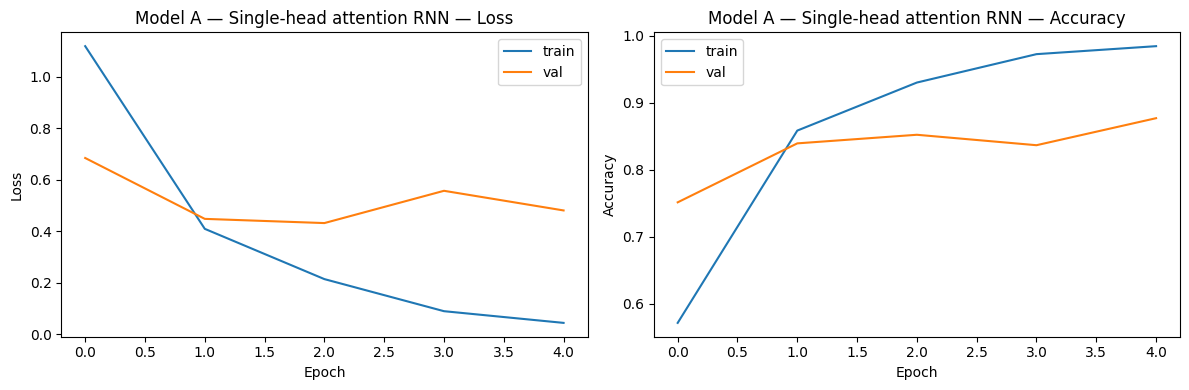

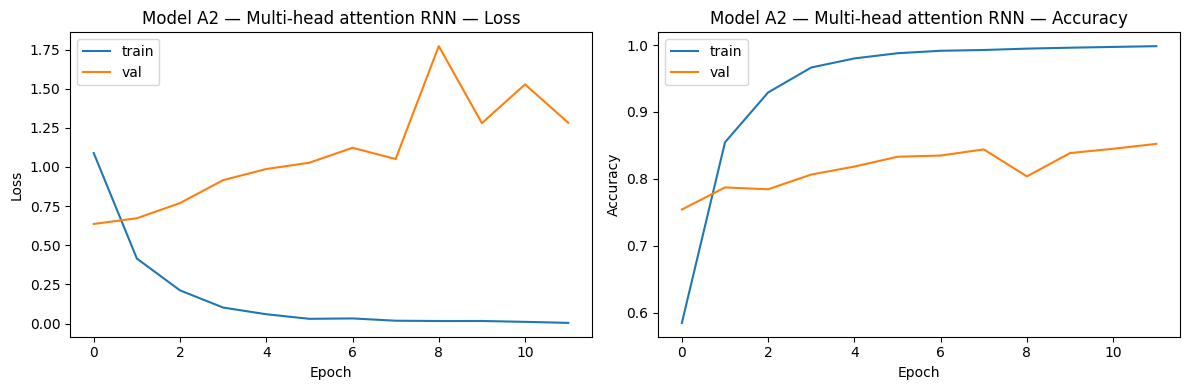

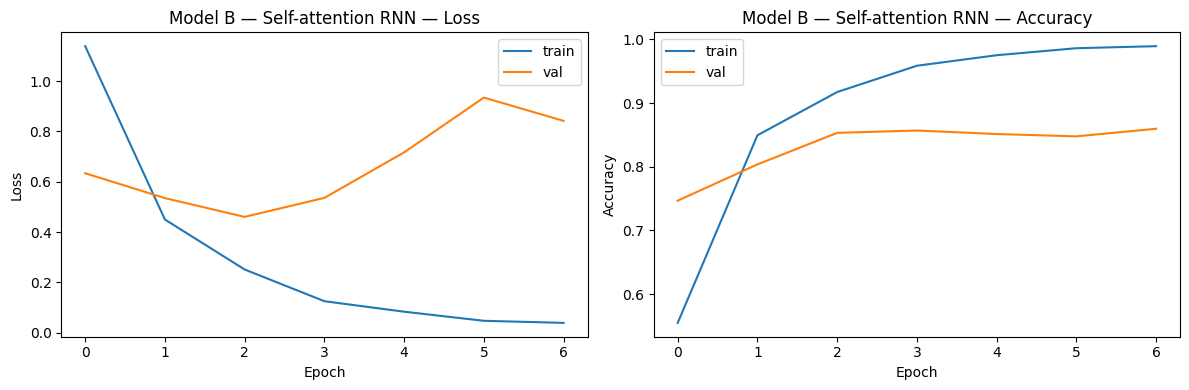

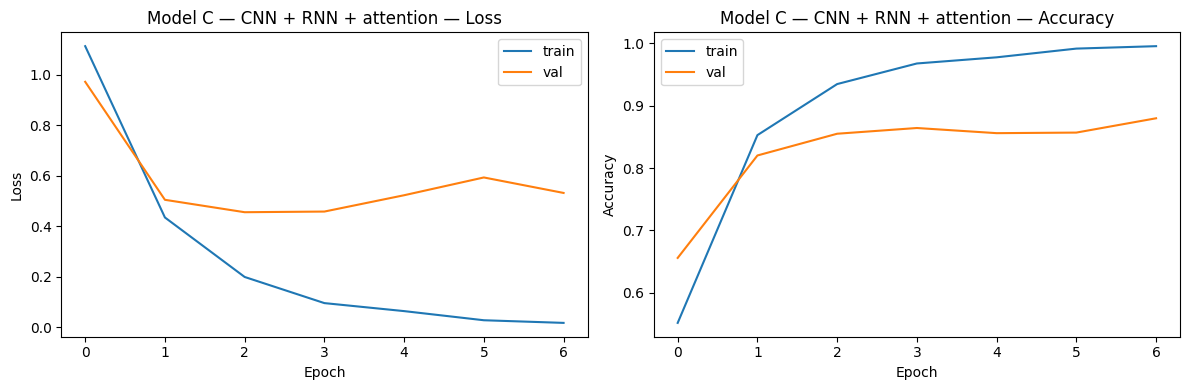

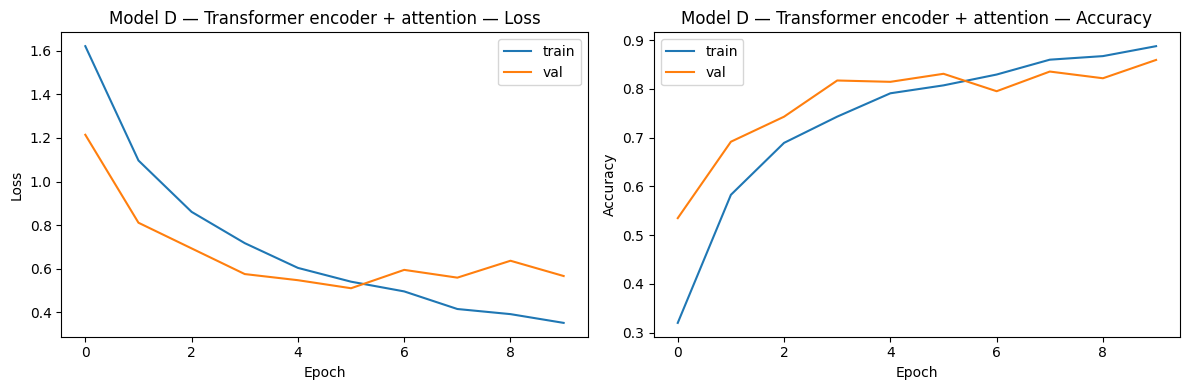

In [99]:

plotted_any = False

for exp in EXPERIMENTS:
    history_path = Path(exp['history_path'])
    if not history_path.exists():
        print(f"History not found for {exp['label']} at {history_path}.")
        continue

    data = np.load(history_path, allow_pickle=True)
    train_loss = data['train_loss']
    train_acc = data['train_acc']
    val_loss = data['val_loss']
    val_acc = data['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='val')
    axes[0].set_title(f"{exp['label']} — Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='val')
    axes[1].set_title(f"{exp['label']} — Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plotted_any = True

if not plotted_any:
    print("No saved histories found yet. Train an experiment to populate the plots.")


### Attention map diagnostics

To show what each enhancement actually focuses on, we probe trained checkpoints and plot token-level attention weights for a few representative validation questions. Darker cells highlight tokens that a model considers more salient.


Question (LOC): What 's the capital of Taiwan ?
Model A — Single-head attention RNN: predicted LOC (p=1.00) | gold=LOC
Model A2 — Multi-head attention RNN: predicted LOC (p=1.00) | gold=LOC
Model B — Self-attention RNN: predicted LOC (p=1.00) | gold=LOC


/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Model C — CNN + RNN + attention: predicted LOC (p=1.00) | gold=LOC
Model D — Transformer encoder + attention: predicted LOC (p=1.00) | gold=LOC
Question (ENTY): What is the first book of the Old Testament ?
Model A — Single-head attention RNN: predicted ENTY (p=1.00) | gold=ENTY
Model A2 — Multi-head attention RNN: predicted ENTY (p=1.00) | gold=ENTY
Model B — Self-attention RNN: predicted ENTY (p=1.00) | gold=ENTY
Model C — CNN + RNN + attention: predicted ENTY (p=1.00) | gold=ENTY
Model D — Transformer encoder + attention: predicted ENTY (p=1.00) | gold=ENTY
Question (ABBR): What is the abbreviated term used for the National Bureau of Investigation ?
Model A — Single-head attention RNN: predicted ENTY (p=0.97) | gold=ABBR


/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are n

Model A2 — Multi-head attention RNN: predicted ABBR (p=1.00) | gold=ABBR
Model B — Self-attention RNN: predicted ABBR (p=1.00) | gold=ABBR
Model C — CNN + RNN + attention: predicted ENTY (p=1.00) | gold=ABBR
Model D — Transformer encoder + attention: predicted ENTY (p=0.98) | gold=ABBR


/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_92655/1365601607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


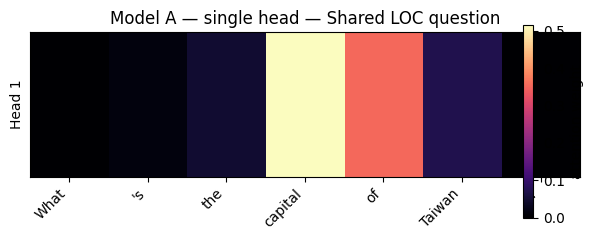

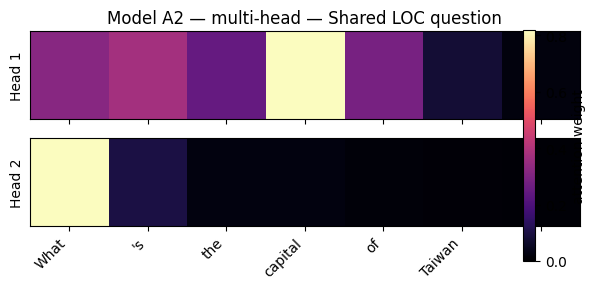

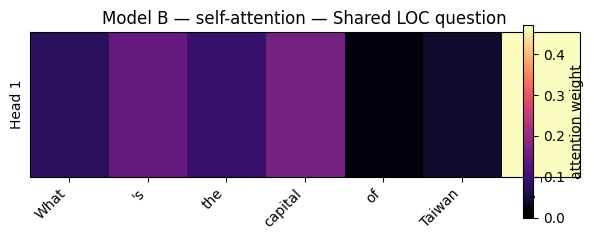

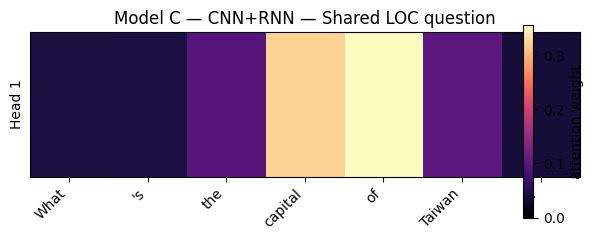

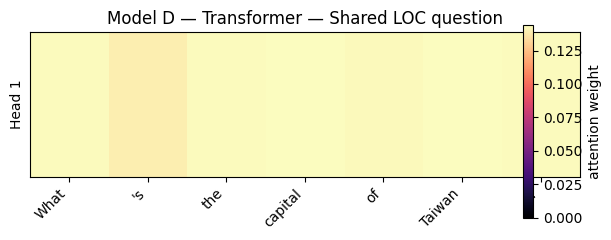

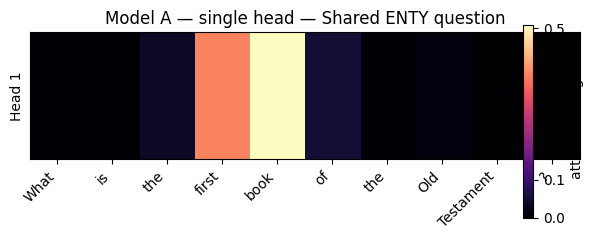

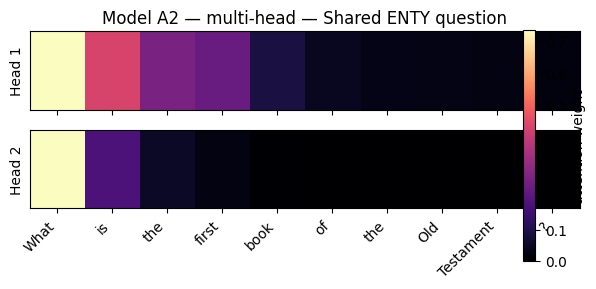

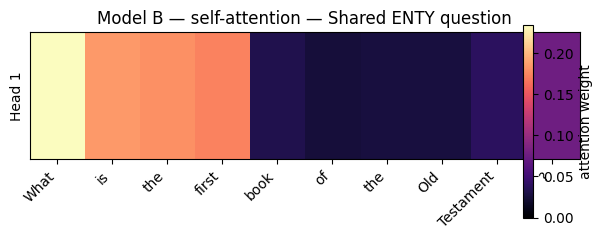

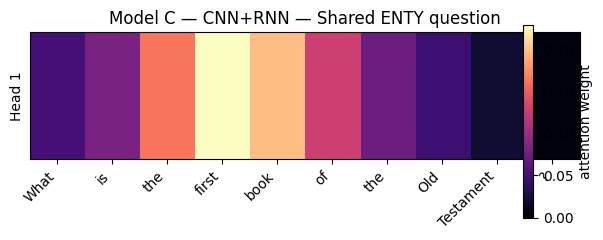

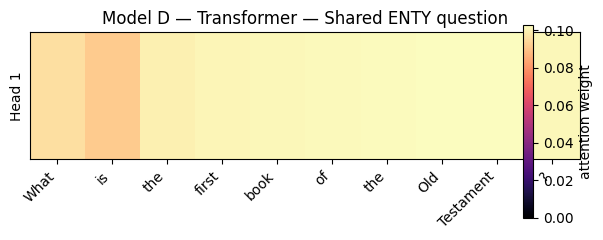

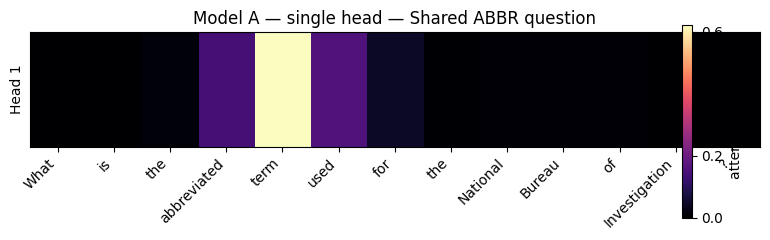

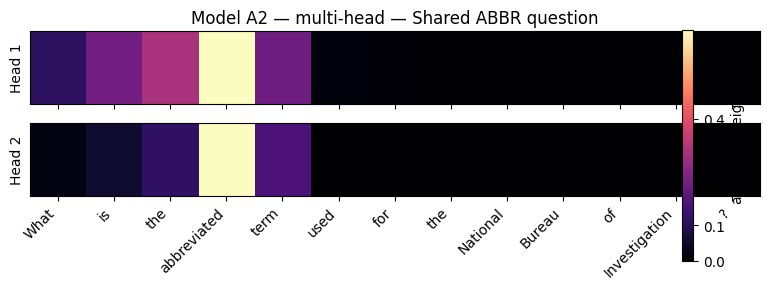

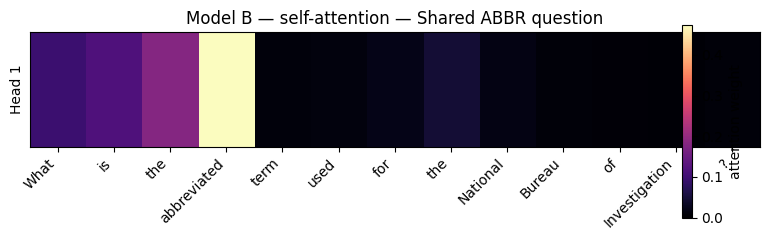

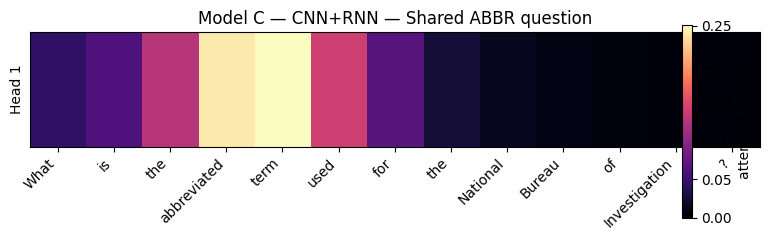

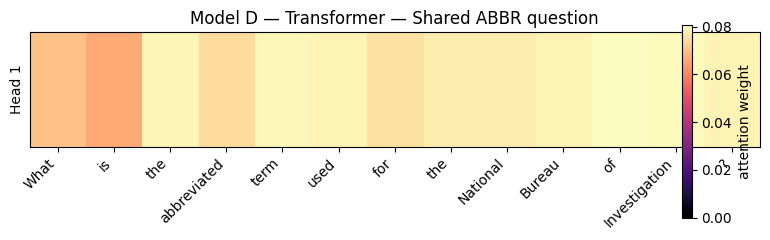

In [100]:
EXPERIMENT_LOOKUP = {exp['name']: exp for exp in EXPERIMENTS}
MODEL_CACHE = {}
UNK_IDX = TEXT.vocab.stoi.get(TEXT.unk_token, 0)


def get_trained_model(exp_name):
    if exp_name not in EXPERIMENT_LOOKUP:
        raise KeyError(f"Unknown experiment: {exp_name}")
    if exp_name not in MODEL_CACHE:
        cfg = EXPERIMENT_LOOKUP[exp_name]
        model = build_model(cfg)
        state = torch.load(cfg['best_path'], map_location=DEVICE)
        model.load_state_dict(state)
        model.to(DEVICE)
        model.eval()
        MODEL_CACHE[exp_name] = model
    return MODEL_CACHE[exp_name]


def prepare_tokens(sample, max_tokens=32):
    if isinstance(sample, str):
        tokens = TEXT.preprocess(sample)
    else:
        tokens = list(sample)
    if not tokens:
        raise ValueError("Cannot visualize attention for an empty token list.")
    tokens = tokens[:max_tokens]
    ids = [TEXT.vocab.stoi.get(tok, UNK_IDX) for tok in tokens]
    text_tensor = torch.tensor(ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
    lengths = torch.tensor([len(tokens)], dtype=torch.long, device=DEVICE)
    return tokens, text_tensor, lengths


def attention_to_matrix(weights, valid_len):
    if weights is None:
        raise RuntimeError("Model did not store attention weights during the forward pass.")
    attn = weights.detach().cpu()
    if attn.dim() == 3:
        attn = attn.squeeze(0).transpose(0, 1)
    elif attn.dim() == 2:
        attn = attn.squeeze(0).unsqueeze(0)
    else:
        attn = attn.unsqueeze(0)
    attn = attn[:, :valid_len]
    denom = attn.sum(dim=1, keepdim=True).clamp_min(1e-9)
    return (attn / denom).numpy()


def plot_attention(tokens, attn_matrix, title):
    heads = attn_matrix.shape[0]
    fig_height = max(2.5, heads * 1.5)
    fig_width = max(6.0, len(tokens) * 0.6)
    fig, axes = plt.subplots(heads, 1, figsize=(fig_width, fig_height), sharex=True)
    if heads == 1:
        axes = [axes]
    img = None
    for idx, ax in enumerate(axes):
        img = ax.imshow(attn_matrix[idx][None, :], aspect='auto', cmap='magma', vmin=0.0)
        ax.set_yticks([])
        ax.set_ylabel(f"Head {idx + 1}")
        if idx == 0:
            ax.set_title(title)
    axes[-1].set_xticks(range(len(tokens)))
    axes[-1].set_xticklabels(tokens, rotation=45, ha='right')
    fig.colorbar(img, ax=axes, fraction=0.025, pad=0.02, label='attention weight')
    fig.tight_layout()


def visualize_attention(exp_name, sample, gold_label=None, title=None, max_tokens=32):
    tokens, text_tensor, lengths = prepare_tokens(sample, max_tokens=max_tokens)
    model = get_trained_model(exp_name)
    model.eval()
    with torch.no_grad():
        logits = model(text_tensor, lengths)
        probs = torch.softmax(logits, dim=-1).squeeze(0)
    pred_idx = int(probs.argmax())
    pred_label = LABEL.vocab.itos[pred_idx]
    confidence = float(probs[pred_idx])
    attn_matrix = attention_to_matrix(model.last_attention, len(tokens))
    desc = EXPERIMENT_LOOKUP[exp_name]['label']
    msg = f"{desc}: predicted {pred_label} (p={confidence:.2f})"
    if gold_label is not None:
        msg += f" | gold={gold_label}"
    print(msg)
    caption = title or f"{desc} — attention over tokens"
    plot_attention(tokens, attn_matrix, caption)


def pick_example(label=None, offset=0, dataset=valid_data):
    matches = [ex for ex in dataset.examples if label is None or ex.label == label]
    if not matches:
        raise ValueError(f"No examples found for label={label}.")
    return matches[offset % len(matches)]


ATTN_MODELS = [
    {"exp": "model_a_single", "title": "Model A — single head"},
    {"exp": "model_a_multihead", "title": "Model A2 — multi-head"},
    {"exp": "model_b_self_attn", "title": "Model B — self-attention"},
    {"exp": "model_c_cnn_rnn", "title": "Model C — CNN+RNN"},
    {"exp": "model_d_transformer", "title": "Model D — Transformer"},
]

ATTN_SAMPLE_CASES = [
    {"label": "LOC", "offset": 2, "title": "Shared LOC question"},
    {"label": "ENTY", "offset": 2, "title": "Shared ENTY question"},
    {"label": "ABBR", "offset": 1, "title": "Shared ABBR question"},
]

for case in ATTN_SAMPLE_CASES:
    example = pick_example(label=case['label'], offset=case.get('offset', 0))
    question = ' '.join(example.text)
    print(f"Question ({example.label}): {question}")
    for model_spec in ATTN_MODELS:
        visualize_attention(
            exp_name=model_spec['exp'],
            sample=example.text,
            gold_label=example.label,
            title=f"{model_spec['title']} — {case.get('title', 'Shared example')}",
            max_tokens=case.get('max_tokens', 32),
        )
